### First observations concerning the dataset

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import librosa
import IPython.display as ipd
import librosa.display as lid
cmap = matplotlib.colormaps['viridis']

In [2]:
### CONFIGURATION CLASS TAKEN FROM THE OFFICIAL NOTEBOOK OF THE CONTEST

class CFG:
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 64
    
    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    
    # Number of epochs, model name
    epochs = 10
    preset = 'efficientnetv2_b2_imagenet'
    
    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 24
    class_names = sorted(os.listdir('birdclef-2024/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

In [3]:
df_birds = pd.read_csv('birdclef-2024/eBird_Taxonomy_v2021.csv')
df_metadata = pd.read_csv('birdclef-2024/train_metadata.csv')
print(df_birds.shape, df_metadata.shape)

(16753, 9) (24459, 12)


In [13]:
df_birds.head(3)

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
2,7,slash,y00934,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN


In [14]:
df_metadata.head(3)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg


#### Répartitions des espèces par ordre

In [7]:
fig = px.histogram(df_birds, x='ORDER1')
fig.show()

#### Check of data consistency

In [10]:
nans_per_column = df_birds.isna().sum().reset_index()
nans_per_column.columns = ['Column', 'Empty values']

fig = px.bar(nans_per_column, x='Column', y='Empty values', title='Nombre de NaNs par colonne')
fig.show()

In [4]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def spectral_gate(S, noise_mean, threshold):
    mask = S > (noise_mean[:, np.newaxis] * threshold)
    S_denoised = S * mask
    return S_denoised


def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=CFG.sample_rate, 
                                   n_mels=256,
                                   n_fft=2048,
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio("birdclef-2024/train_audio/"+str(row.filename))
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Noise profile
    noise_profile = audio[:int(0.5 * sr)]
    D_noise = librosa.stft(noise_profile)
    noise_mean = np.mean(np.abs(D_noise), axis=1)
    #Spectral gate
    spec_denoised= spectral_gate(spec,noise_mean,2.2)
    spec_denoised_db = librosa.amplitude_to_db(spec_denoised, ref=np.max)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                 color= cmap(0.1))
    # Specplot
    lid.specshow(spec_denoised_db, 
                 sr = CFG.sample_rate, 
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

In [35]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath, sr=CFG.sample_rate)
    return audio, sr

def spectral_gate(S, noise_mean, threshold):
    mask = S > (noise_mean[:, np.newaxis] * threshold)
    S_denoised = S * mask
    return S_denoised

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=CFG.sample_rate, 
                                   n_mels=256,
                                   n_fft=2048,
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin)
    return spec

def mel_to_audio(mel_spec, sr, n_fft=2048, hop_length=512):
    # Inverse the mel spectrogram to the linear spectrogram
    inv_mel_spec = librosa.feature.inverse.mel_to_stft(mel_spec, sr=sr, n_fft=n_fft)
    # Perform inverse STFT to get the time-domain signal
    audio_reconstructed = librosa.griffinlim(inv_mel_spec, hop_length=hop_length, n_iter=32)
    return audio_reconstructed

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio("birdclef-2024/train_audio/"+str(row.filename))
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    spec_db = librosa.power_to_db(spec, ref=np.max)
    
    # Noise profile
    noise_profile = audio[:int(0.5 * sr)]
    spec_noise = get_spectrogram(noise_profile)
    noise_mean = np.mean(spec_noise, axis=1)
    
    # Spectral gate
    spec_denoised = spectral_gate(spec, noise_mean, 2.2)
    spec_denoised_db = librosa.power_to_db(spec_denoised, ref=np.max)
    
    # Convert the denoised mel spectrogram back to audio
    audio_denoised = mel_to_audio(spec_denoised, sr=sr)

    # Plot the original and denoised waveforms and spectrograms
    fig, ax = plt.subplots(4, 1, figsize=(12, 16), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    
    # Original Waveplot
    librosa.display.waveshow(audio, sr=CFG.sample_rate, ax=ax[0])
    ax[0].set_title('Original Audio')
    
    # Original Spectrogram
    librosa.display.specshow(spec_db, sr=CFG.sample_rate, hop_length=512, x_axis='time', y_axis='mel', cmap='coolwarm', ax=ax[1])
    ax[1].set_title('Original Spectrogram')
    
    # Denoised Waveplot
    librosa.display.waveshow(audio_denoised, sr=CFG.sample_rate, ax=ax[2])
    ax[2].set_title('Denoised Audio')
    
    # Denoised Spectrogram
    librosa.display.specshow(spec_denoised_db, sr=CFG.sample_rate, hop_length=512, x_axis='time', y_axis='mel', cmap='coolwarm', ax=ax[3])
    ax[3].set_title('Denoised Spectrogram')
    
    plt.show()
    
    # Play the original and denoised audio
    print("# Original Audio:")
    ipd.display(ipd.Audio(audio, rate=CFG.sample_rate))
    print("# Denoised Audio:")
    ipd.display(ipd.Audio(audio_denoised, rate=CFG.sample_rate))


primary_label                                                  barswa
secondary_labels                                                   []
type                                          ['call', 'flight call']
latitude                                                      53.9299
longitude                                                     -2.9833
scientific_name                                       Hirundo rustica
common_name                                              Barn Swallow
author                                                    Chris Batty
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            2.5
url                                      http://xeno-canto.org/690497
filename                                          barswa/XC690497.ogg
Name: 1111, dtype: object


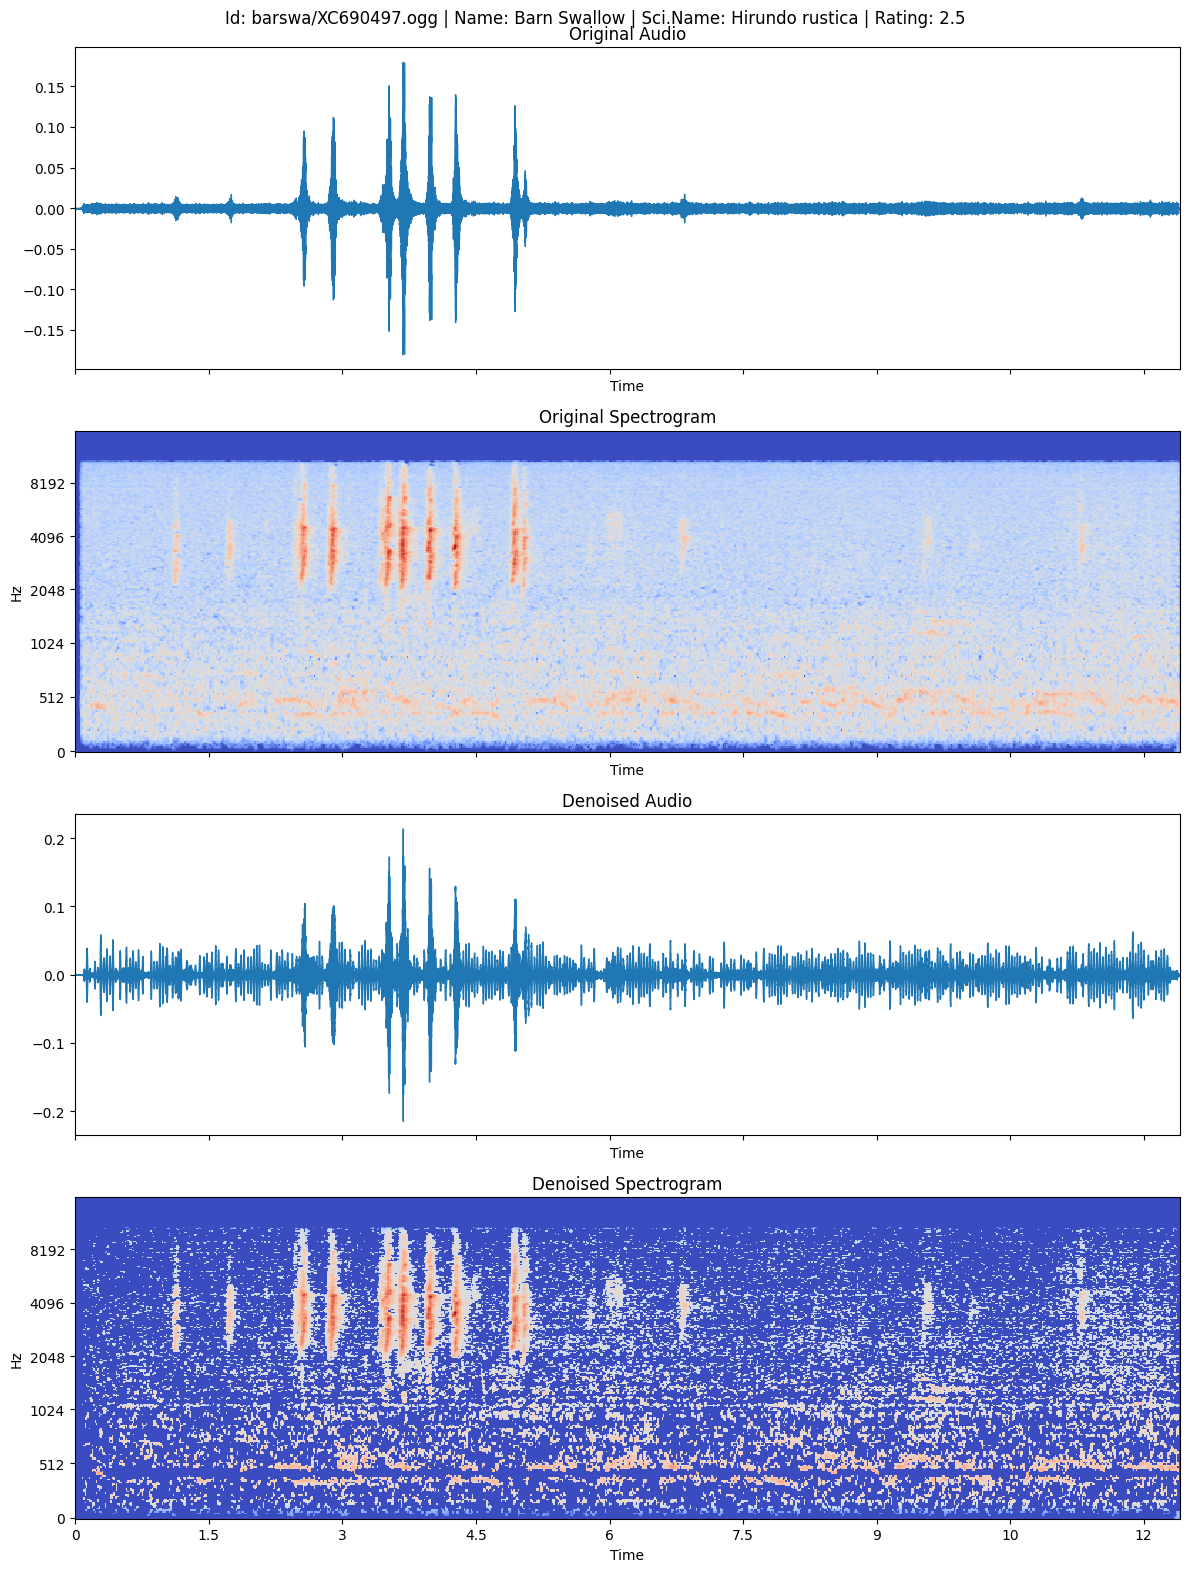

# Original Audio:


# Denoised Audio:


In [36]:
row = df_metadata.iloc[1111]

# Display audio
print(row)
display_audio(row)

In [ ]:
def save_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio("birdclef-2024/train_audio/" + str(row.filename))
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    spec_db = librosa.power_to_db(spec, ref=np.max)
    
    # Noise profile
    noise_profile = audio[:int(0.5 * sr)]
    spec_noise = get_spectrogram(noise_profile)
    noise_mean = np.mean(spec_noise, axis=1)
    
    # Spectral gate
    spec_denoised = spectral_gate(spec, noise_mean, 2.2)
    spec_denoised_db = librosa.power_to_db(spec_denoised, ref=np.max)
    
    # Convert the denoised mel spectrogram back to audio
    audio_denoised = mel_to_audio(spec_denoised, sr=sr)
    
    # Save the denoised audio file
    output_audio_path = os.path.splitext("birdclef-2024/train_audio/" + str(row.filename))[0] + '_denoised.wav'
    librosa.output.write_wav(output_audio_path, audio_denoised, sr)
    
    # Plot the original and denoised waveforms and spectrograms
    fig, ax = plt.subplots(4, 1, figsize=(12, 16), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    
    # Original Waveplot
    librosa.display.waveshow(audio, sr=CFG.sample_rate, ax=ax[0])
    ax[0].set_title('Original Audio')
    
    # Original Spectrogram
    librosa.display.specshow(spec_db, sr=CFG.sample_rate, hop_length=512, x_axis='time', y_axis='mel', cmap='coolwarm', ax=ax[1])
    ax[1].set_title('Original Spectrogram')
    
    # Denoised Waveplot
    librosa.display.waveshow(audio_denoised, sr=CFG.sample_rate, ax=ax[2])
    ax[2].set_title('Denoised Audio')
    
    # Denoised Spectrogram
    librosa.display.specshow(spec_denoised_db, sr=CFG.sample_rate, hop_length=512, x_axis='time', y_axis='mel', cmap='coolwarm', ax=ax[3])
    ax[3].set_title('Denoised Spectrogram')
    
    # Save the denoised spectrogram
    output_image_path = os.path.splitext("birdclef-2024/train_audio/" + str(row.filename))[0] + '_denoised_spectrogram.png'
    plt.savefig(output_image_path)
    plt.close(fig)
    
def process_all_rows(df):
    for idx, row in df.iterrows():
        save_audio(row)